# Adversarial Acoustics - Embeddings

This notebook walks you through creating embeddings of your voice. In particular we want you to explore how difference in represented in the embedding space and how this compares to a perceptual and socially constructed understanding of difference. 

In this notebook we will use code from the [Resemblyzer](https://github.com/resemble-ai/Resemblyzer) Github repo. You can find more on Resemblyzer in the embeddings further material frame in the workshop Figjam. The repo provides several other machine learning methods for voice analysis worth exploring.

>Resemblyzer allows you to derive a **high-level representation of a voice** through a deep learning model (referred to as the voice encoder). Given an audio file of speech, it creates a summary vector of 256 values (an embedding, often shortened to "embed" in this repo) that summarizes the characteristics of the voice spoken.


## Setup
Cloning the Resemblyzer repo, installing and importing prerequisite libraries

In [ ]:
!git clone https://github.com/resemble-ai/Resemblyzer.git
!pip install -r /content/Resemblyzer/requirements_demos.txt
!pip install -r /content/Resemblyzer/requirements_package.txt
!pip install ffmpeg-python

Cloning into 'Resemblyzer'...
remote: Enumerating objects: 608, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 608 (delta 1), reused 6 (delta 1), pack-reused 602
Receiving objects: 100% (608/608), 101.47 MiB | 38.61 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.9 MB/s 
     |████████████████████████████████| 66 kB 3.7 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 4.6 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72477 sha256=cdcf0ee5882576712de4537bae3f3e6171ca523629e17393bb06d6778dc9d84b
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
  Created w

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd Resemblyzer/
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from resemblyzer import sampling_rate, preprocess_wav, VoiceEncoder
from matplotlib import cm
from time import sleep, perf_counter as timer
from umap import UMAP
from sys import stderr
from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy

_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [255, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
], dtype=np.float) / 255 

def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True, 
                     title="", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(30, 10))
        
    # Compute the 2D projections. You could also project to another number of dimensions (e.g. 
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs)
    projs = reducer.fit_transform(embeds)
    
    # Draw the projections
    speakers = np.array(speakers)
    colors = colors or _my_colors
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        marker = "o" if markers is None else markers[i]
        label = speaker if legend else None
        ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)

    if legend:
        ax.legend(title="Speakers", ncol=2)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
    return projs

/content/Resemblyzer


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Create your dataset
The next cells allow you to create a dataset of audio recordings. Later we will plot the embedding space of the dataset. You should use the label and recordings cells recursively to create a multi label dataset. Create a label and record several utterances for that label, then repeat this with another label.

We leave the labelling up to you. Perhaps you could start with each member of your group speaking the same text, or if you are working alone, you might try repeating the same phrases with different stresses on your voice and see where they sit in the embedding space. 

If you're familiar with how to upload files to a Colab notebook (if you'd like be just ask us) it's also possible to upload a dataset. Make sure your dataset follows the file path convention `content/Resemblyzer/audio_data/<your-data-set-name>/<label-name>/<your-recording01>.wav` and proceed to the embedding cell.

In [ ]:
#@title Prep for recording
#@markdown Importing method for recording inline, run this cell only once.
# Method is from https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=57xW3GSb6gv0 , only edited button messages

"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Press to stop recording";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#@title Create your recording directory
#@markdown Name your dataset (avoid spaces or special character as they will break the logic in the next cells). You can create multiple datasets by running this cell more than once, however, the code below will use the most recently created dataset by default. Feel free to change the code if you'd like to use a different logic.
name = "embeddings-dataset" #@param {type:"string"}
dir_path = '/content/Resemblyzer/audio_data/' + name
!mkdir $dir_path
print("New directory created at: " + dir_path)

New directory created at: /content/Resemblyzer/audio_data/embeddings-dataset


In [ ]:
#@title Choose a label
#@markdown Name your label (avoid spaces or special character as they will break the logic in the next cells).
label = "second-label" #@param {type:"string"}
rec_path = dir_path + '/' + label
!mkdir $rec_path
print("New directory created at: " + rec_path)

New directory created at: /content/Resemblyzer/audio_data/embeddings-dataset/second-label


In [ ]:
#@title Record your audio
#@markdown Start the recording by running the cell. Stop the recording using the button.
#@markdown You may need to give your browser permission to access your microphone. Create as many recordings as you would like for the current label. When you're done creating records for this label, enter a new name in field in the cell above and reapeat the process. 
from datetime import datetime
audio, sr = get_audio()
time = datetime.now().strftime("%H%M%S")
ext = '.wav'
full_rec_path = rec_path + '/' + 'recording' + time + ext

# save the audio
scipy.io.wavfile.write(full_rec_path, sr, audio)
print("New recorded created at: " + full_rec_path)

New recorded created at: /content/Resemblyzer/audio_data/embeddings-dataset/second-label/recording111930.wav


## Encode and analyse audio

In [ ]:
## Gather the wavs
wav_fpaths = list(Path("audio_data", dir_path).glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))))
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}

Preprocessing wavs: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
## Compute the embeddings
encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

Loaded the voice encoder model on cpu in 0.05 seconds.


## Plot Embeddings

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


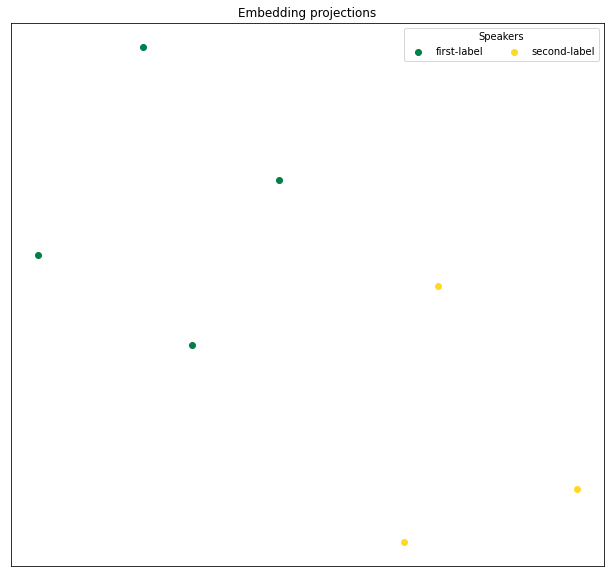

In [ ]:
## Project the embeddings in 2D space
plot_projections(utterance_embeds, speakers, title="Embedding projections")
plt.show()